
# Triage Efficiency

(how long it takes to triage the scene) What record in the FRVRS log is there that shows that the scene triage is complete?


## 0. Importing libraries and FRVRS logs dataframe and creating still patients dataframe

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 109)


In [4]:

# Get the time that all still patients are engaged
if nu.pickle_exists('still_patients_df'):
    still_patients_df = nu.load_object('still_patients_df')
else:
    groupby_columns = ['session_uuid', 'time_group']
    gb = frvrs_logs_df.sort_values(['elapsed_time']).groupby(groupby_columns)
    sort_columns_list = [cn for cn in frvrs_logs_df.columns if cn.endswith('_sort')]
    action_types_list = [
        'TELEPORT', 'S_A_L_T_WALK_IF_CAN', 'S_A_L_T_WAVE_IF_CAN', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'BAG_ACCESS', 'TOOL_HOVER',
        'TOOL_SELECTED', 'INJURY_TREATED', 'TOOL_APPLIED', 'TAG_SELECTED', 'TAG_APPLIED', 'BAG_CLOSED', 'TAG_DISCARDED',
        'TOOL_DISCARDED'
    ]
    command_messages_list = [
        'walk to the safe area', 'wave if you can', 'are you hurt', 'reveal injury', 'lay down', 'where are you', 'can you hear',
        'anywhere else', 'what is your name', 'hold still', 'sit up/down', 'stand up'
    ]
    rows_list = []
    for (session_uuid, time_group), df1 in gb:
        logger_version = df1.logger_version.unique().item()
        
        # Get list of patients in a scene that are still
        mask_series = False
        for cn in sort_columns_list: mask_series |= (df1[cn] == 'still')
        still_list = df1[mask_series].patient_id.unique().tolist()
    
        # Get the list of first engagements with all still patients
        for patient_id in still_list:
            row_dict = {}
            row_dict['logger_version'] = logger_version
            for cn in groupby_columns: row_dict[cn] = eval(cn)
            row_dict['patient_id'] = patient_id
            
            # Get the patient's first notice
            patient_mask_series = (df1.patient_id == patient_id)
            first_notice = df1[patient_mask_series].elapsed_time.min()
            row_dict['first_notice'] = first_notice
            
            # Get the first action with the patient
            mask_series = patient_mask_series & df1.action_type.isin(action_types_list)
            mask_series |= ((df1.action_type == 'VOICE_COMMAND') & (df1.voice_command_message.isin(command_messages_list)))
            first_action = df1[mask_series].elapsed_time.min()
            row_dict['first_action'] = first_action
            
            # Get the patient's first engagement
            mask_series = patient_mask_series & (df1.action_type == 'PATIENT_ENGAGED')
            df2 = df1[mask_series]
            if df2.shape[0]:
                first_engagement = df2.elapsed_time.min()
                notice_to_engagement = first_engagement - first_notice
                action_to_engagement = first_engagement - first_action
            else:
                first_engagement = np.nan
                notice_to_engagement = np.nan
                action_to_engagement = np.nan
            row_dict['first_engagement'] = first_engagement
            row_dict['notice_to_engagement'] = notice_to_engagement
            row_dict['action_to_engagement'] = action_to_engagement
            
            rows_list.append(row_dict)
    still_patients_df = DataFrame(rows_list)
    nu.store_objects(still_patients_df=still_patients_df)

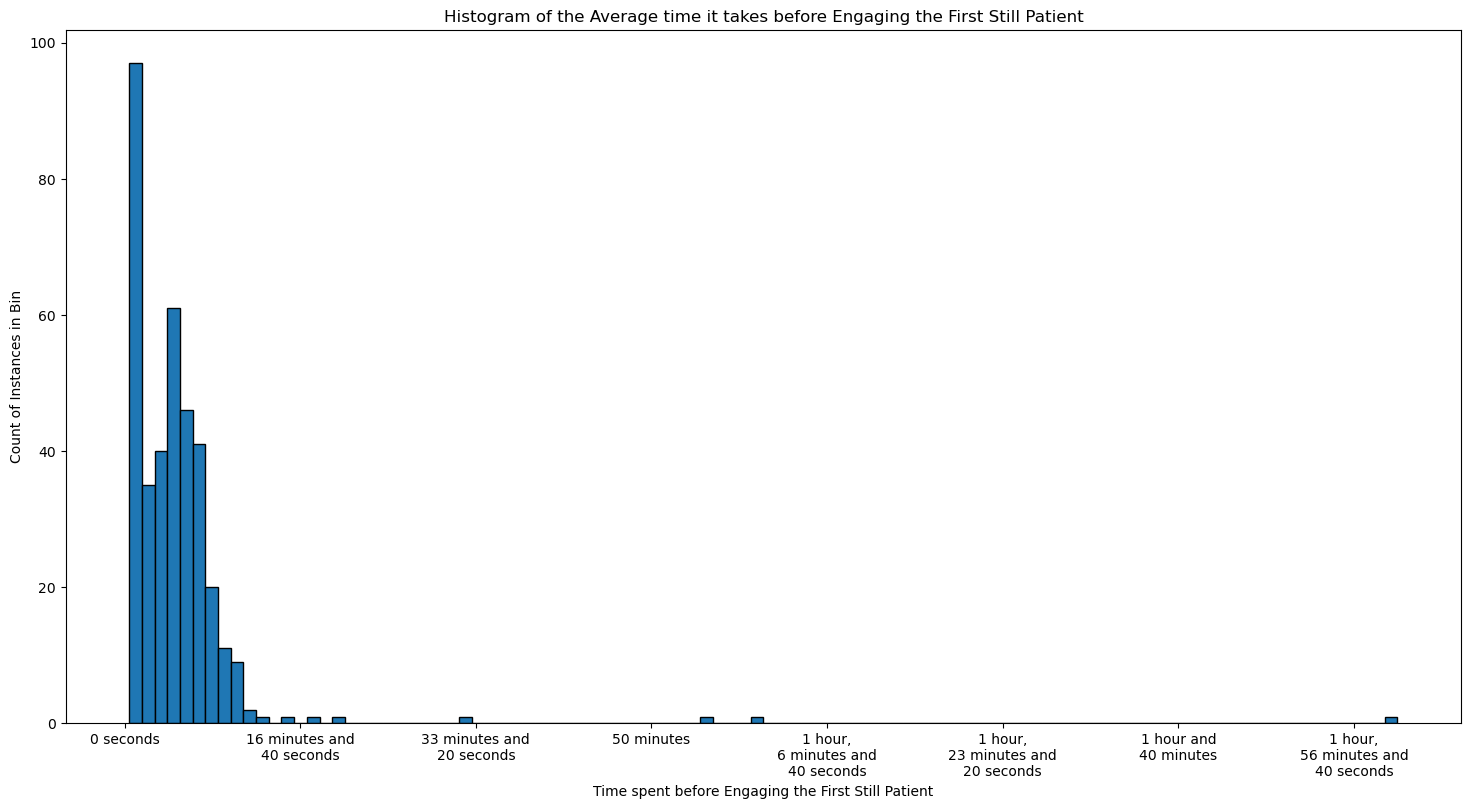

In [5]:

# Get the time to engage the first stills
groupby_columns = ['session_uuid', 'time_group']
min_first_engagement_df = still_patients_df.groupby(groupby_columns).filter(
    lambda df: not df.first_engagement.isnull().any()
).groupby(groupby_columns).min().reset_index(drop=False).sort_values('first_engagement')
df = min_first_engagement_df.rename(
    columns={k: 'min_' + k for k in min_first_engagement_df.columns if k not in groupby_columns}
)

# Histogram of the time that it takes to triage the scene (assuming a still patient is the first engaged)
xlabel = 'Time spent before Engaging the First Still Patient'
get_xtick_text = lambda text_obj: humanize.precisedelta(
    timedelta(milliseconds=text_obj.get_position()[0])
).replace(', ', ',\n').replace(' and ', ' and\n')
title = 'Histogram of the Average time it takes before Engaging the First Still Patient'
nu.plot_histogram(df, 'min_first_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title)

In [6]:

def show_long_runs(df, column_name, milliseconds, delta_fn, description):
    delta = delta_fn(milliseconds)
    print(f'\nThese files have {description} than {delta}:')
    mask_series = (df[column_name] > milliseconds)
    session_uuid_list = df[mask_series].session_uuid.tolist()
    mask_series = frvrs_logs_df.session_uuid.isin(session_uuid_list)
    logs_folder = '../data/logs'
    import csv
    from datetime import datetime
    for old_file_name in frvrs_logs_df[mask_series].file_name.unique():
        old_file_path = os.path.join(logs_folder, old_file_name)
        with open(old_file_path, 'r') as f:
            reader = csv.reader(f, delimiter=',', quotechar='"')
            for values_list in reader:
                date_str = values_list[2]
                break
            try: date_obj = datetime.strptime(date_str, '%m/%d/%Y %H:%M')
            except ValueError: date_obj = datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p')
            new_file_name = date_obj.strftime('%y.%m.%d.%H%M.csv')
            new_sub_directory = old_file_name.split('/')[0]
            new_file_path = new_sub_directory + '/' + new_file_name
            print(f'{old_file_name} (or {new_file_path})')

In [7]:

# We would never have someone in the headset for 2 hours.
# Any runs longer than that 16 minutes and 40 seconds was probably an instance
# of someone taking off the headset and setting it on the ground.
# 1 second = 1000 milliseconds; 1 minute = 60 seconds
sixteen_minutes_forty_seconds = 1_000 * 60 * 16 + 1_000 * 40
delta_fn = lambda x: humanize.precisedelta(timedelta(milliseconds=x))
description = 'runs longer'
show_long_runs(df, 'min_first_engagement', sixteen_minutes_forty_seconds, delta_fn, description)


These files have runs longer than 16 minutes and 40 seconds:
v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a270.csv (or v.1.0/23.05.16.1459.csv)
v.1.0/Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv (or v.1.0/23.05.16.1615.csv)
v.1.0/clean-9d142377-69d6-4622-958d-a29a6a0a0d21.csv (or v.1.0/23.05.09.0810.csv)
v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa46.csv (or v.1.0/23.06.12.1430.csv)


In [8]:

# The long one was probably taking off the headset and leaving it on while going to lunch.
# Can you tell me which files have the unusually long durations? Anything over 50 minutes is bogus.
# 1 second = 1000 milliseconds; 1 minute = 60 seconds
fifty_minutes = 1_000 * 60 * 50
delta_fn = lambda x: humanize.precisedelta(timedelta(milliseconds=x))
description = 'runs longer'
show_long_runs(df, 'min_first_engagement', fifty_minutes, delta_fn, description)


These files have runs longer than 50 minutes:
v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a270.csv (or v.1.0/23.05.16.1459.csv)
v.1.0/Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv (or v.1.0/23.05.16.1615.csv)
v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa46.csv (or v.1.0/23.06.12.1430.csv)


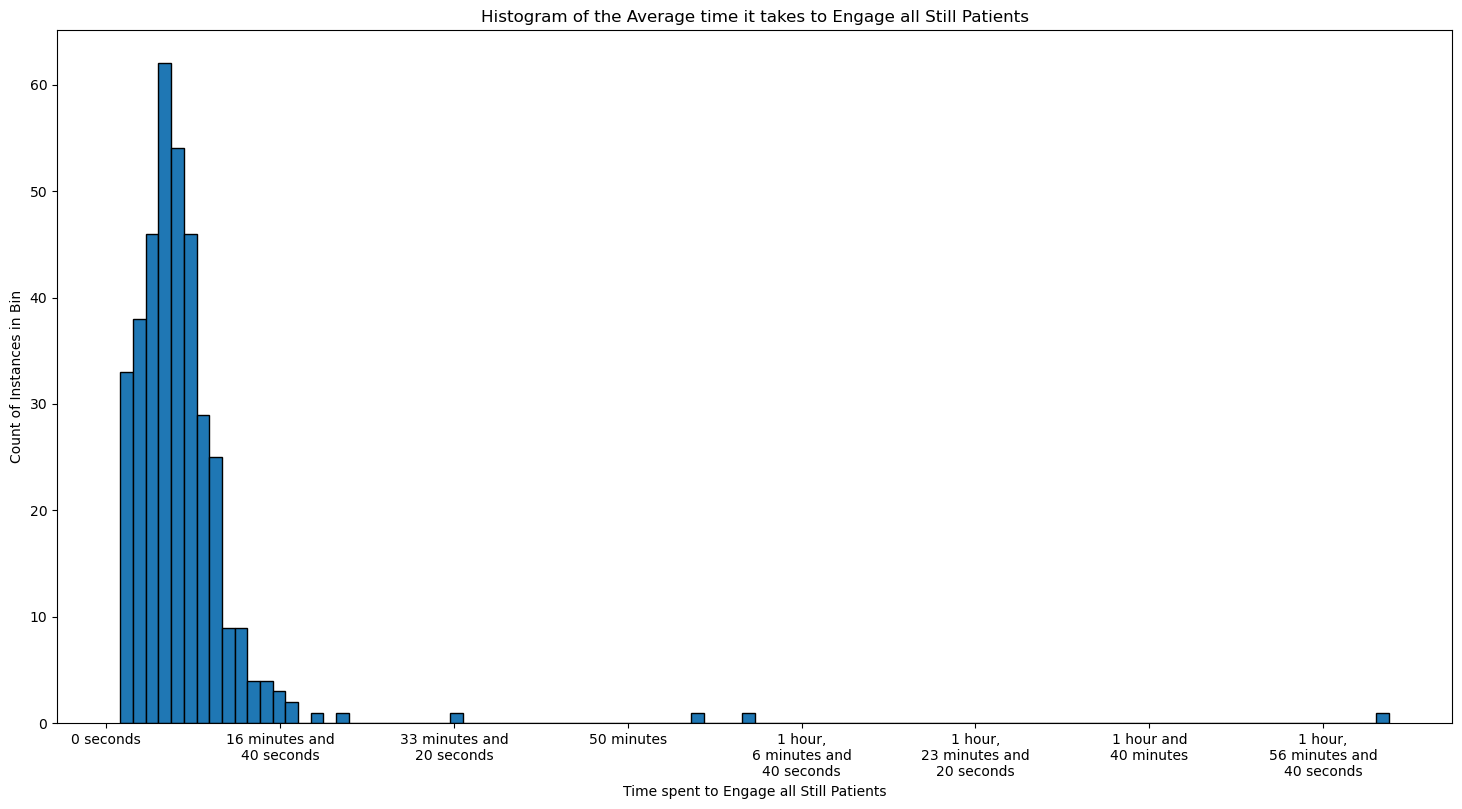

In [9]:

# Get the time to engage all stills
groupby_columns = ['session_uuid', 'time_group']
max_first_engagement_df = still_patients_df.groupby(groupby_columns).filter(
    lambda df: not df.first_engagement.isnull().any()
).groupby(groupby_columns).max().reset_index(drop=False).sort_values('first_engagement')
df = max_first_engagement_df.rename(
    columns={k: 'max_' + k for k in max_first_engagement_df.columns if k not in groupby_columns}
)

# Histogram of the time that all still patients are engaged
xlabel = 'Time spent to Engage all Still Patients'
get_xtick_text = lambda text_obj: humanize.precisedelta(
    timedelta(milliseconds=text_obj.get_position()[0])
).replace(', ', ',\n').replace(' and ', ' and\n')
title = 'Histogram of the Average time it takes to Engage all Still Patients'
nu.plot_histogram(df, 'max_first_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title)

In [10]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

,317,267,118,205
session_uuid,e0b7bea0-1cf9-42a8-a02c-e8699a962779,bd13e705-6cf0-4adc-a628-c605c4ae6a3e,4f66ee10-3104-44ec-8d31-9e1c2b33f36d,8ceb28a3-e268-4930-a1c6-84cac4f6239c
time_group,1,1,1,2
max_logger_version,1.0,1.0,1.0,1.0
max_patient_id,Gary_3 Root,Mike_6 Root,Gary_3 Root,Gary_3 Root
max_first_notice,256711,15818,23586,213122
max_first_action,258216.0,26361.0,36557.0,220856.0
max_first_engagement,341466.0,198992.0,114012.0,279051.0
max_notice_to_engagement,84755.0,183174.0,90426.0,65929.0
max_action_to_engagement,83250.0,172631.0,77455.0,58195.0


In [11]:

# Show examples of "still" records from the sort columns
sort_columns_list = [cn for cn in frvrs_logs_df.columns if cn.endswith('_sort')]
mask_series = False
for cn in sort_columns_list: mask_series |= (frvrs_logs_df[cn] == 'still')
df = frvrs_logs_df[mask_series]

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

,723919,790749,66434,695364
action_type,PATIENT_RECORD,PATIENT_ENGAGED,PATIENT_DEMOTED,PATIENT_RECORD
elapsed_time,1125038,646991,11697,6203441
event_time,2023-03-03 13:39:00,2023-05-10 11:30:00,2023-04-19 09:49:21,2023-05-16 17:58:00
session_uuid,e8cb6ae0-6d68-410f-88fc-4adf30d8bfac,d2c676e2-fddc-4872-9a26-b621d6585df9,fd1c7057-2c2d-4dec-9297-92ef0621c15e,724fdf45-3165-43b8-b9ca-dc07102d2886
file_name,v.1.0/Clean Marty8.csv,v.1.0/clean-d2c676e2-fddc-4872-9a26-b621d6585d...,All CSV files renamed by date/04.19.23.0958.csv,v.1.0/Clean 724fdf45-3165-43b8-b9ca-dc07102d28...
logger_version,1.0,1.0,1.3,1.0
time_group,3,2,0,15
patient_demoted_health_level,NaN,NaN,100,NaN
patient_demoted_health_time_remaining,NaN,NaN,128,NaN
patient_demoted_id,NaN,NaN,Mike_3 Root,NaN


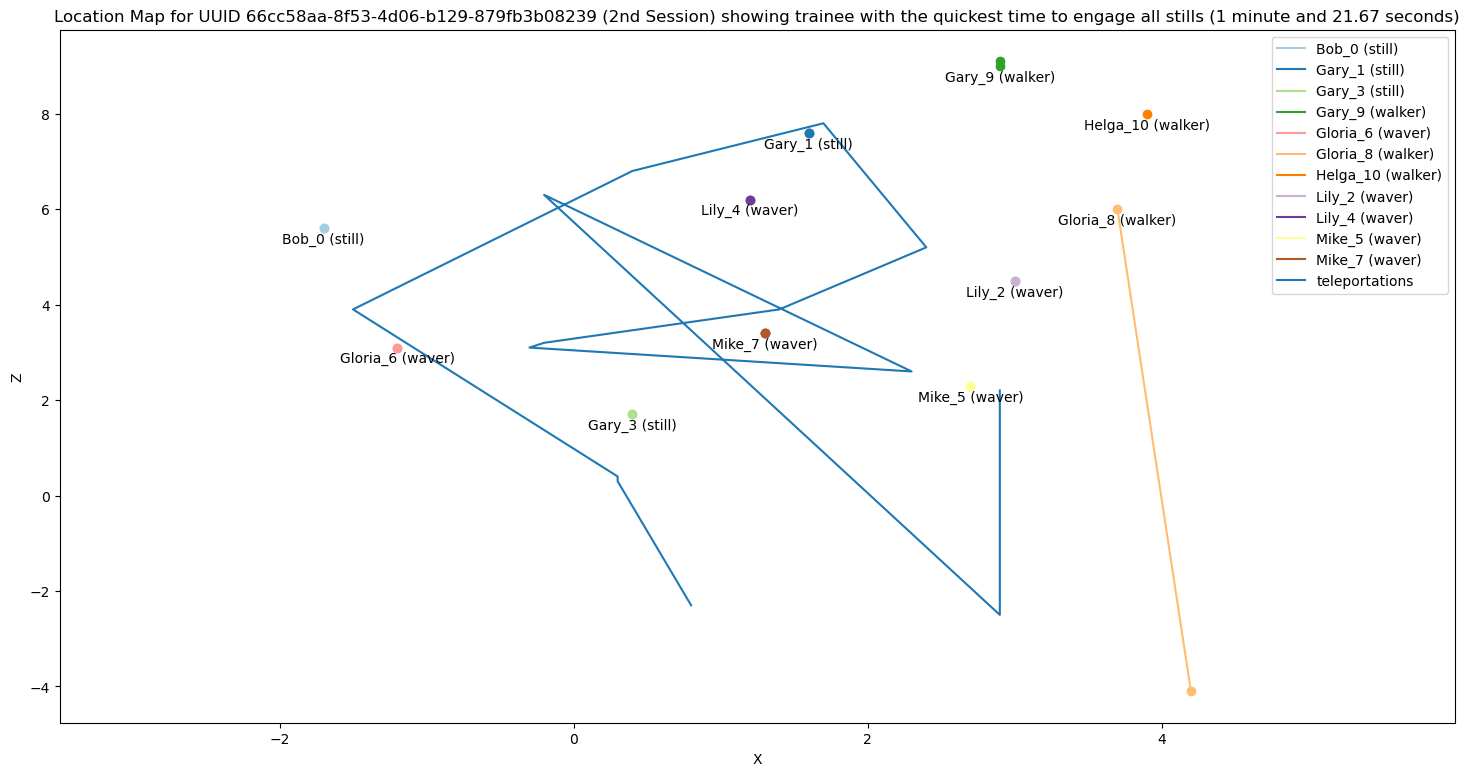

In [12]:

# Get scene with the quickest time to engage all stills
df = max_first_engagement_df.head(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    time_group = df.time_group.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.time_group == time_group)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(time_group+1)} Session)'
    title += ' showing trainee with the quickest time to engage all stills ('
    first_engagement = df.first_engagement.min()
    title += humanize.precisedelta(timedelta(milliseconds=first_engagement)) + ')'
    nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)


## In looking at the maps, does a small footprint correlate to efficient performance?

In [13]:

# Create a euclidean footprint measure
if nu.pickle_exists('euclidean_footprint_df'):
    euclidean_footprint_df = nu.load_object('euclidean_footprint_df')
else:
    df1 = max_first_engagement_df.rename(
        columns={k: 'max_' + k for k in max_first_engagement_df.columns if k not in groupby_columns}
    )
    groupby_columns = ['session_uuid', 'time_group', 'max_first_engagement']
    gb = df1.groupby(groupby_columns)
    rows_list = []
    for (session_uuid, time_group, max_first_engagement), df2 in gb:
        # display(df2.T)
        
        # Filter for this specific scene
        session_mask = True
        for cn in groupby_columns[:-1]: session_mask &= (frvrs_logs_df[cn] == eval(cn))
        
        # Add locations to the dimension variables
        mask_series = (frvrs_logs_df.action_type == 'PLAYER_LOCATION') & session_mask
        locations_df = frvrs_logs_df[mask_series]
        
        # Add teleportations to the dimension variables
        mask_series = (frvrs_logs_df.action_type == 'TELEPORT') & session_mask
        teleports_df = frvrs_logs_df[mask_series]
        
        # Add the teleports_df DataFrame to the bottom of the locations_df DataFrame
        combined_df = pd.concat([
            locations_df.rename(columns={'player_location_location': 'player_location'}),
            teleports_df.rename(columns={'teleport_location': 'player_location'})
        ], ignore_index=True)

        # Get the xyz coords sorted by elapsed time
        x_dim = []; y_dim = []; z_dim = []
        if combined_df.shape[0]:
            combined_df = combined_df.sort_values(['elapsed_time'])
            for player_location in combined_df.player_location:
                player_location = eval(player_location)
                x_dim.append(player_location[0])
                y_dim.append(player_location[1])
                z_dim.append(player_location[2])
        
        # Starting from (0,0,0), sum the Euclidean distances
        first_point = '(0, 0, 0)'
        euclidean_distance = 0
        for (x, y, z) in zip(x_dim, y_dim, z_dim):
            second_point = f'({x}, {y}, {z})'
            euclidean_distance += nu.get_euclidean_distance(second_point, first_point=first_point)
            first_point = second_point
        # print(euclidean_distance)
        row_dict = {}
        for cn in groupby_columns: row_dict[cn] = eval(cn)
        row_dict['euclidean_distance'] = euclidean_distance
        rows_list.append(row_dict)
    euclidean_footprint_df = DataFrame(rows_list)
    nu.store_objects(euclidean_footprint_df=euclidean_footprint_df)

In [14]:

df = euclidean_footprint_df.corr()
y = 'euclidean_distance'
mask_series = (df.index == y)
x = 'max_first_engagement'
c = round(df[mask_series][x].squeeze(), 3)
print(f'The correlation of {y} to {x} is about {c}, so no.')

The correlation of euclidean_distance to max_first_engagement is about 0.007, so no.


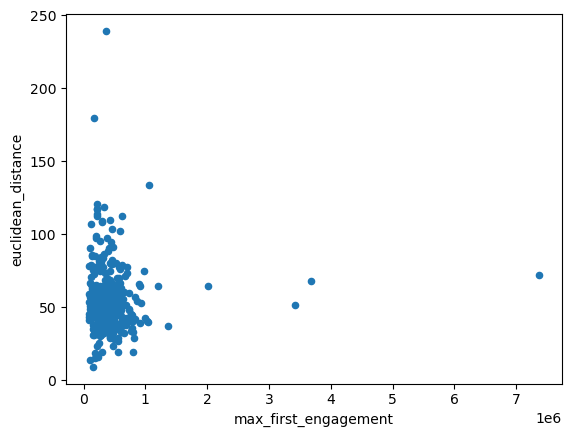

In [15]:

euclidean_footprint_df.plot(x='max_first_engagement', y='euclidean_distance', kind='scatter');

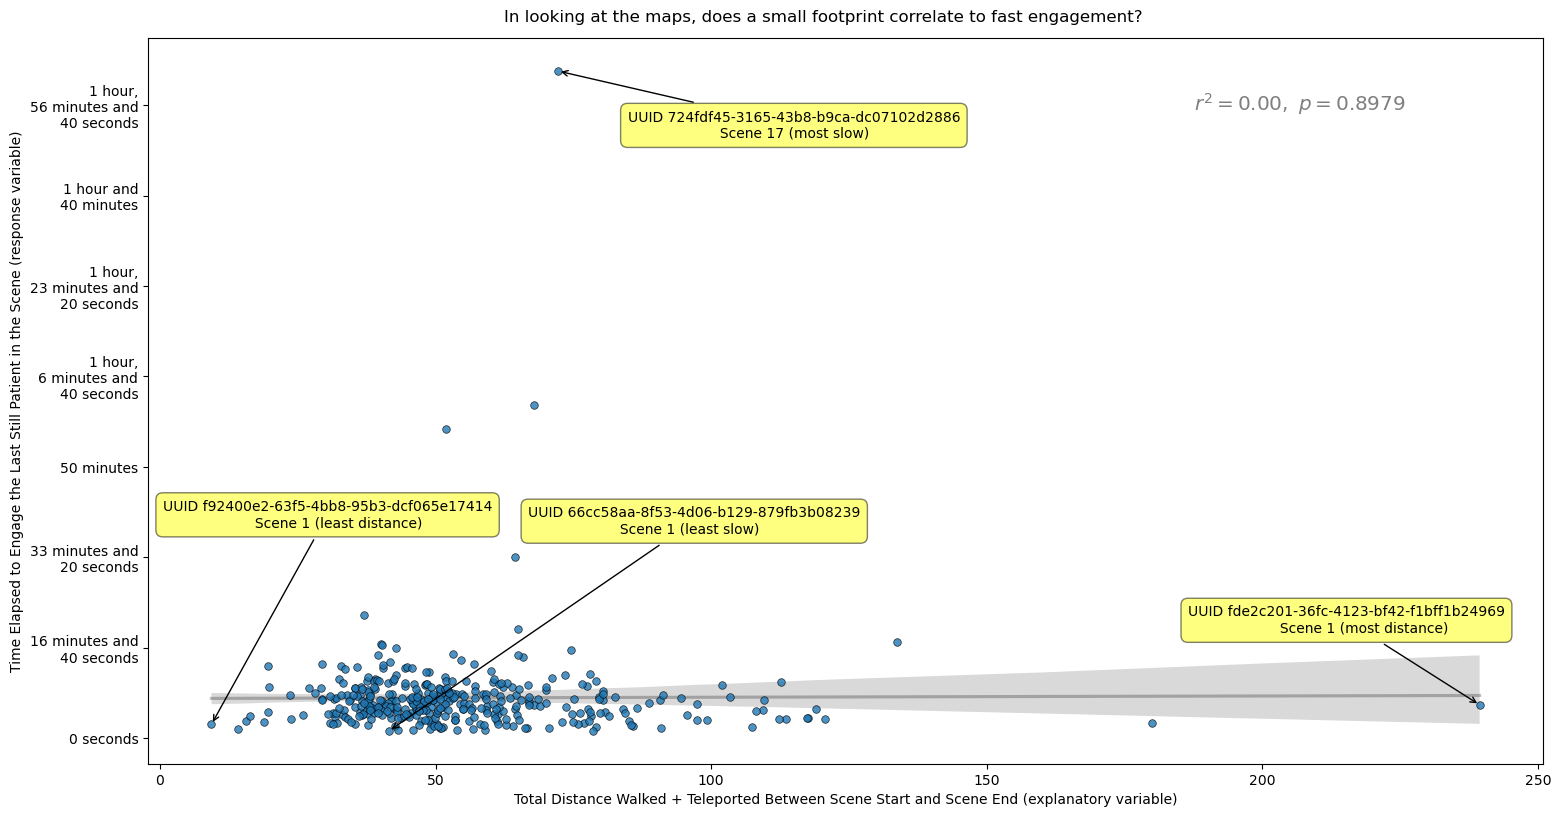

In [34]:

# Distance travelled and efficiency vs accuracy
# (ie in looking at the maps, does a small footprint correlate to efficient performance?)
groupby_columns = ['session_uuid', 'time_group']
df = euclidean_footprint_df.set_index(groupby_columns)
df.index = pd.Index([f'UUID {idx_tuple[0]}\n                     Scene {idx_tuple[1]}' for idx_tuple in df.index.tolist()])
fig = nu.first_order_linear_scatterplot(
    df,
    'euclidean_distance',
    'max_first_engagement',
    xlabel_str='Total Distance Walked + Teleported Between Scene Start and Scene End (explanatory variable)',
    ylabel_str='Time Elapsed to Engage the Last Still Patient in the Scene (response variable)',
    x_adj='distance',
    y_adj='slow',
    title='In looking at the maps, does a small footprint correlate to fast engagement?',
    idx_reference=None,
    annot_reference=None,
    aspect_ratio=None,
    least_x_xytext=(-35, 140),
    most_x_xytext=(-210, 50),
    least_y_xytext=(100, 140),
    most_y_xytext=(50, -50),
    reference_xytext=None,
    color_list=None,
)
ax = fig.get_axes()[0]

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.intword(int(text_obj.get_position()[0]))
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list)

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list);

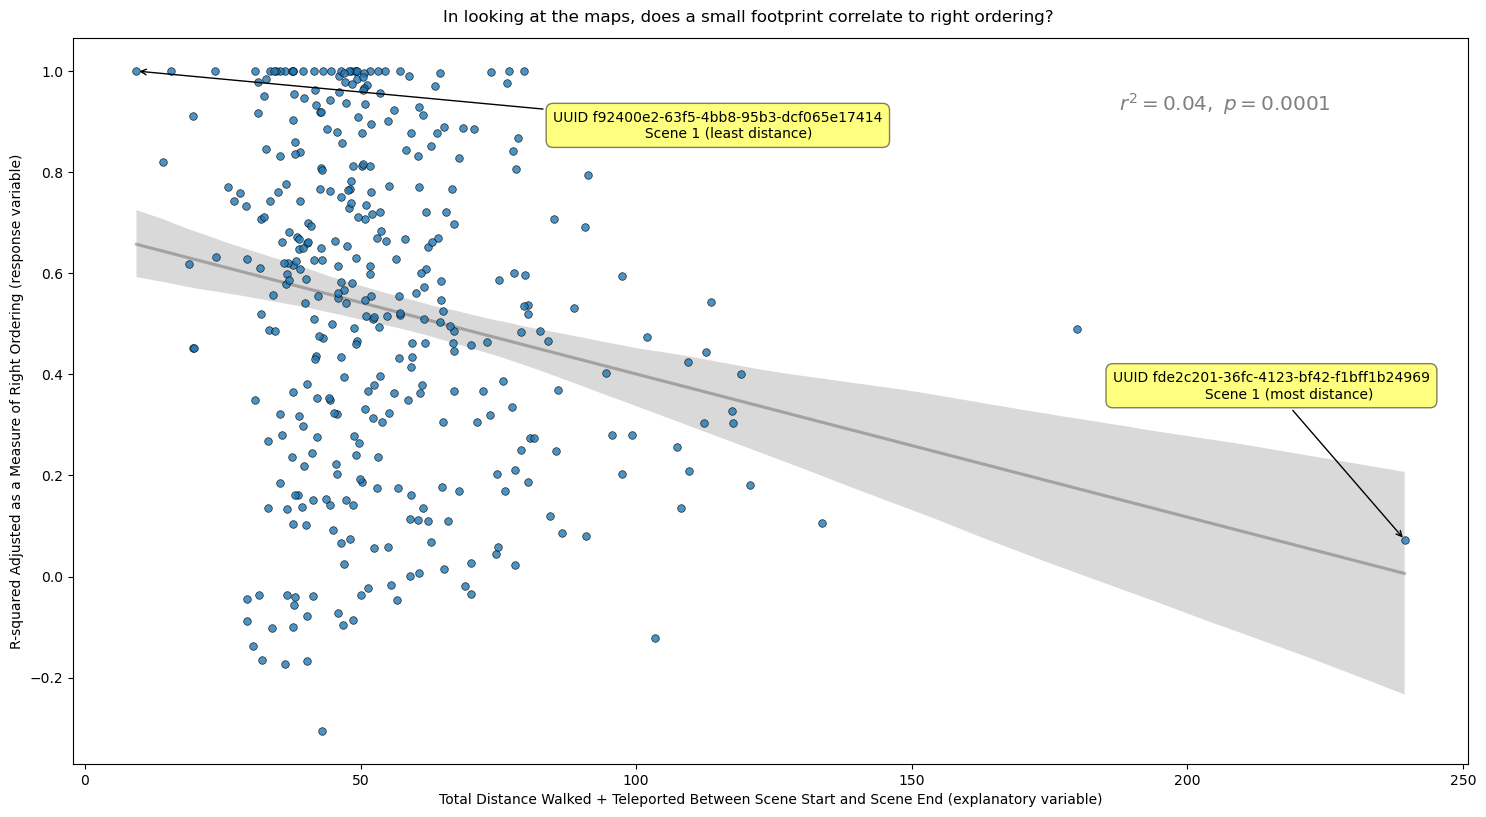

In [35]:

# Distance travelled and efficiency vs accuracy
# (ie in looking at the maps, does a small footprint correlate to efficient performance?)
engagment_sort_df = nu.load_object('engagment_sort_df')
groupby_columns = list(set(euclidean_footprint_df.columns).intersection(set(engagment_sort_df.columns)))
df = engagment_sort_df.merge(euclidean_footprint_df, on=groupby_columns, how='inner').set_index(groupby_columns)
df.index = pd.Index([f'UUID {idx_tuple[0]}\n                     Scene {idx_tuple[1]}' for idx_tuple in df.index.tolist()])
fig = nu.first_order_linear_scatterplot(
    df,
    'euclidean_distance',
    'rsquared_adj',
    xlabel_str='Total Distance Walked + Teleported Between Scene Start and Scene End (explanatory variable)',
    ylabel_str='R-squared Adjusted as a Measure of Right Ordering (response variable)',
    x_adj='distance',
    y_adj='ideal',
    title='In looking at the maps, does a small footprint correlate to right ordering?',
    idx_reference=None,
    annot_reference=None,
    aspect_ratio=None,
    least_x_xytext=(300, -50),
    most_x_xytext=(-210, 100),
    least_y_xytext=(100, 140),
    most_y_xytext=(50, -50),
    reference_xytext=None,
    color_list=None,
)
ax = fig.get_axes()[0]

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.intword(int(text_obj.get_position()[0]))
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list);

In [17]:

# Investigate the presence of still patients
fn = lambda x: 'still' in str(x).lower()
srs = frvrs_logs_df.applymap(fn, na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
print(columns_list)

mask_series = frvrs_logs_df.voice_capture_message.map(fn)
df = frvrs_logs_df[mask_series]
if df.shape[0]: print(df.sample(min(5, df.shape[0])).voice_capture_message.unique().tolist())

mask_series = frvrs_logs_df.voice_command_command_description.map(fn)
df = frvrs_logs_df[mask_series]
if df.shape[0]: print(df.sample(min(5, df.shape[0])).voice_command_command_description.unique().tolist())

for cn in columns_list:
    print(cn)
    mask_series = frvrs_logs_df[cn].map(fn)
    df = frvrs_logs_df[mask_series]
    
    # Display a sample of the data frame, dropping columns with all NaN values and transposing it
    display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

['patient_demoted_sort', 'voice_capture_message', 'voice_command_message', 'voice_command_command_description', 'patient_record_sort', 'patient_engaged_sort']
["go to still bleeding so i'm gonna turn to kick her", "well i'm still gonna make him a red tag i think cause you know i'll shoot you right i forgot to do that", "someone that you walk up to on you check a call so you don't have a pulse but they have agonal respirations and there's nothing you can do for them so say like if they're left hemisphere is laying on the pavement and they're still you know trying to breathe that's gonna be something you can't fix so that's gonna be a great day OK Yep alright", 'still', "girl you first he may be a distractor but oh there we go Oh no he's not OK you're still standing awesome you can sit down if you want"]
['he walked for me but still', "I wouldn't change them I still would keep them green but I guess we could put him here since he's not gonna walk", "I mean this guy was walking in wave bu

,714824,789453,802825,743582
action_type,PATIENT_DEMOTED,PATIENT_DEMOTED,PATIENT_DEMOTED,PATIENT_DEMOTED
elapsed_time,536841,262525,199758,109810
event_time,2023-03-08 10:47:00,2023-05-09 09:18:00,2023-05-09 10:03:00,2023-06-23 09:27:00
session_uuid,89c48e7e-780f-4f1b-a846-fc0f4fd9841c,d0e616ae-5458-42c9-a013-55b8f3b51b06,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,6d21f440-1c45-4c53-ad64-4edb92a94e25
file_name,v.1.0/Clean Marty24.csv,v.1.0/clean-d0e616ae-5458-42c9-a013-55b8f3b51b...,v.1.0/clean-ff97fc56-c803-4aa7-b419-35e0ac17d0...,v.1.0/clean-6d21f440-1c45-4c53-ad64-4edb92a94e...
logger_version,1.0,1.0,1.0,1.0
time_group,1,1,1,1
patient_demoted_health_level,100,100,100,100
patient_demoted_health_time_remaining,0,Infinity,Infinity,0
patient_demoted_id,Gary_3 Root,Bob_0 Root,Bob_0 Root,Gary_3 Root


voice_capture_message


,148153,68044,134605,618686
action_type,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE
elapsed_time,260607,333026,266905,404628
event_time,2022-12-07 10:27:26,2023-04-19 10:07:28,2022-12-01 12:41:16,2022-03-15 08:51:34
session_uuid,5ebf3067-e1a6-4711-810d-60095452c24c,f3cbb8a9-8d0c-48f0-ac0c-e379ac4d9411,17962d45-8e90-4b50-86e7-77451042aac8,5d916938-e0d3-47ee-8f55-12bf12283ee1
file_name,All CSV files renamed by date/12.07.22.1031.csv,All CSV files renamed by date/04.19.23.1013.csv,All CSV files renamed by date/12.01.22.1245.csv,Disaster Day 2022/RP_0853.csv
logger_version,1.0,1.3,1.0,1.3
time_group,1,2,1,2
voice_capture_message,so it shows me it's spurting it's still not en...,you know since you can still wave at me,that's nice we'll get to it that's alright see...,i still like
voice_capture_command_description,NaN,NA,NaN,NA


voice_command_message


,92188,773356,101582,735111
action_type,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND
elapsed_time,233518,404590,602879,115439
event_time,2023-04-20 11:38:34,2023-06-12 14:36:00,2023-04-20 13:18:04,2023-06-23 10:26:00
session_uuid,30d6a023-e0a3-4678-9ef2-6011964d225a,a0987257-801e-44c5-a1ad-81e0083bfa46,20168f93-040c-4290-aa7e-2b197825c9de,3459b742-650d-4c82-bb7b-db84a843cc66
file_name,All CSV files renamed by date/04.20.23.1147.csv,v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa...,All CSV files renamed by date/04.20.23.1321.csv,v.1.0/clean-3459b742-650d-4c82-bb7b-db84a843cc...
logger_version,1.3,1.0,1.3,1.0
time_group,1,1,2,1
voice_command_message,hold still,hold still,hold still,hold still
voice_command_command_description,hold still,Yep and he's pretty hold still Sir yeah it's p...,stay still,Oh my grab my crotch area come here stop movin...


voice_command_command_description


,680961,145848,68045,67819
action_type,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND
elapsed_time,225486,278843,333027,148953
event_time,2023-05-12 16:53:00,2022-12-07 08:09:31,2023-04-19 10:07:28,2023-04-19 10:04:24
session_uuid,0b891add-e0c3-463d-948d-7f491f1d10ef,e77c15e0-d0de-413d-a471-20a285e81387,f3cbb8a9-8d0c-48f0-ac0c-e379ac4d9411,f3cbb8a9-8d0c-48f0-ac0c-e379ac4d9411
file_name,v.1.0/Clean 0b891add-e0c3-463d-948d-7f491f1d10...,All CSV files renamed by date/12.07.22.0813.csv,All CSV files renamed by date/04.19.23.1013.csv,All CSV files renamed by date/04.19.23.1013.csv
logger_version,1.0,1.0,1.3,1.3
time_group,1,1,2,1
voice_command_message,walk to the safe area,hold still,wave if you can,sit up/down
voice_command_command_description,OK so you can still walk,hold still,you know since you can still wave at me,girl you first he may be a distractor but oh t...


patient_record_sort


,842537,184558,715369,49109
action_type,PATIENT_RECORD,PATIENT_RECORD,PATIENT_RECORD,PATIENT_RECORD
elapsed_time,107072,31580,20219,18258
event_time,2023-09-07 08:55:46,2023-08-01 07:44:45,2023-03-08 11:27:00,2023-03-14 16:16:52
session_uuid,ff4c3532-5924-45b6-9a6a-d0d3274b6ef0,71a7d2ce-2dea-4bec-8348-028e74fcd092,4ce8ee9f-45ea-42a8-86df-0038c777f040,fc2ed173-5990-4461-9a20-ac856bbb946b
file_name,v.1.3/ff4c3532-5924-45b6-9a6a-d0d3274b6ef0.csv,DCEMS Round 2 only triage sessions/71a7d2ce-2d...,v.1.0/Clean Marty25.csv,All CSV files renamed by date/03.14.23.1621.csv
logger_version,1.3,1.0,1.0,1.3
time_group,2,1,1,1
patient_record_health_level,100,100,100,100
patient_record_health_time_remaining,Infinity,Infinity,Infinity,Infinity
patient_record_id,Military Mike Jungle Burned_0 Root,Bob_0 Root,Bob_0 Root,Gary_1 Root


patient_engaged_sort


,777850,216797,169385,62168
action_type,PATIENT_ENGAGED,PATIENT_ENGAGED,PATIENT_ENGAGED,PATIENT_ENGAGED
elapsed_time,3342449,177338,308258,59374
event_time,2023-06-12 15:25:00,2023-07-26 09:53:26,2023-08-01 14:39:12,2023-03-15 13:36:08
session_uuid,a0987257-801e-44c5-a1ad-81e0083bfa46,17b80e0f-9afe-497f-b3a3-0549c14a4ba9,1813599d-cfde-45f0-8555-428b57478ebb,f92400e2-63f5-4bb8-95b3-dcf065e17414
file_name,v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa...,DCEMS Round 2 only triage sessions/Jeff M.csv,DCEMS Round 2 only triage sessions/1813599d-cf...,All CSV files renamed by date/03.15.23.1338.csv
logger_version,1.0,1.3,1.0,1.0
time_group,8,1,1,1
patient_engaged_health_level,100,100,100,100
patient_engaged_health_time_remaining,0,Infinity,Infinity,0
patient_engaged_id,Gary_3 Root,Gary_1 Root,Gary_1 Root,Gary_3 Root
